# Visualizing the electric field of a capacitor

https://scipython.com/blog/the-electric-field-of-a-capacitor/

The electric field at $\mathbf{r}$ by a charge $q$ at $\mathbf{r_0}$

$$
\mathbf{E(\mathbf{r})} = \frac{q}{|\mathbf{r}-\mathbf{r_0}|^3} (\mathbf{r}-\mathbf{r_0}) 
$$

For a 2D plane, $\mathbf{r} = (x, y)$ and $\mathbf{r_0} = (x_0, y_0)$.

$$
E_x(x, y) = \frac{q}{|\mathbf{r}-\mathbf{r_0}|^3}(x - x_0)
$$

$$
E_y(x, y) = \frac{q}{|\mathbf{r}-\mathbf{r_0}|^3}(y - y_0)
$$

$$
|\mathbf{r}-\mathbf{r_0}| = \sqrt{(x - x_0)^2 + (y - y_0)^2}
$$

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2e/VFPt_dipoles_electric.svg/768px-VFPt_dipoles_electric.svg.png)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

In [ ]:
def E(q, r0, x, y):
    """Return the electric field vector E(x,y)=(Ex, Ey) due to charge q at r0."""
    den = np.hypot(x - r0[0], y - r0[1])**3
    Ex = q * (x - r0[0]) / den
    Ey = q * (y - r0[1]) / den
    return Ex, Ey

The x-coordinates of N charges

$$
x_i = \frac{2i}{N-1} - 1
$$

$$
i = 0, 1, \cdots, N-1
$$

Then $-1 \le x_i \le 1$.

In [ ]:
def get_E(nx, ny, N, d):
    # Grid of x, y points
    x = np.linspace(-5, 5, nx)
    y = np.linspace(-5, 5, ny)
    X, Y = np.meshgrid(x, y)

    # Create a capacitor, represented by two rows of N opposite charges separated
    # by distance d. If d is very small (e.g. 0.1), this looks like a polarized disc.
    charges = []
    for i in range(N):
        xc = (i/(N-1))*2 - 1
        charges.append(( 1, (xc,  d/2)))
        charges.append((-1, (xc, -d/2)))

    # Electric field vector, E=(Ex, Ey), as separate components
    Ex, Ey = np.zeros((ny, nx)), np.zeros((ny, nx))
    for charge in charges:
        ex, ey = E(*charge, x=X, y=Y)
        Ex += ex
        Ey += ey

    return charges, x, y, Ex, Ey

In [ ]:
def draw_results(charges, x, y, Ex, Ey):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, facecolor='k')

    # Plot the streamlines with an appropriate colormap and arrow style
    color = np.log(np.hypot(Ex, Ey))
    ax.streamplot(x, y, Ex, Ey, color=color, linewidth=1, cmap=plt.cm.plasma,
                density=3, arrowstyle='->')

    # Add filled circles for the charges themselves
    charge_colors = {True: '#aa0000', False: '#0000aa'}
    for q, pos in charges:
        ax.add_artist(patches.Circle(pos, 0.05, color=charge_colors[q>0], zorder=10))

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal')
    plt.show()

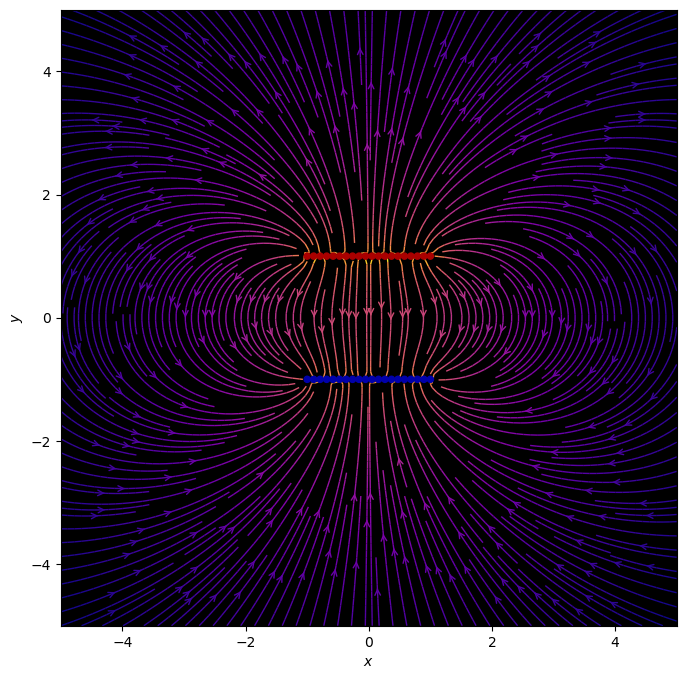

In [ ]:
nx, ny = 128, 128
N, d = 20, 2
draw_results(*get_E(nx, ny, N, d))

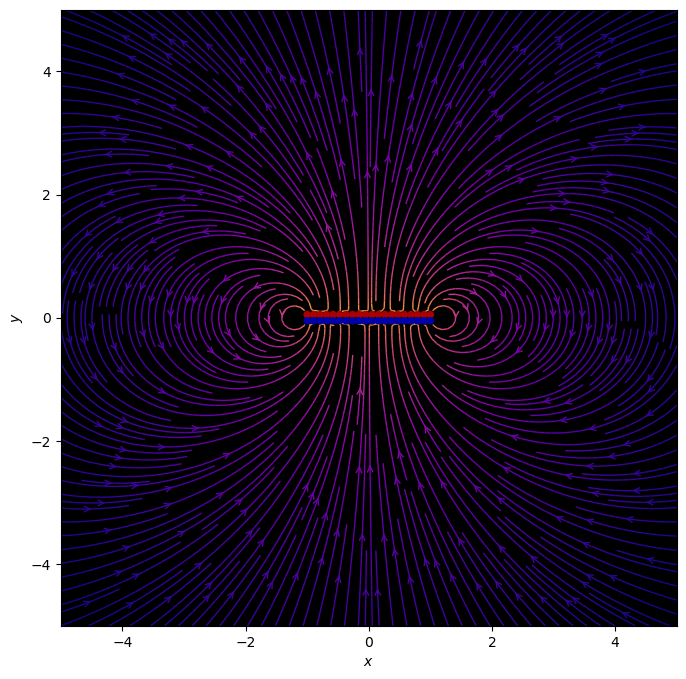

In [ ]:
nx, ny = 128, 128
N, d = 20, 0.1
draw_results(*get_E(nx, ny, N, d))

## Solving streamline ODE

https://www.numbercrunch.de/blog/2013/05/visualizing-streamlines/

In [ ]:
from scipy.integrate import ode

In [ ]:
def draw_streamlines(N, d):
    charges = []
    for i in range(N):
        xc = (i/(N-1))*2 - 1
        charges.append(( 1, (xc,  d/2)))
        charges.append((-1, (xc, -d/2)))

    def E_total(x, y, charges):
        Ex, Ey = 0, 0
        for charge in charges:
            ex, ey = E(*charge, x=x, y=y)
            Ex += ex
            Ey += ey
        return Ex, Ey

    def streamline(t, y, charges):
        Ex, Ey = E_total(y[0], y[1], charges)
        Emag = np.hypot(Ex, Ey)
        return [Ex/Emag, Ey/Emag]

    XMAX, YMAX = 5, 5
    x0, x1 = -XMAX, XMAX
    y0, y1 = -YMAX, YMAX

    xmar, ymar = 0.2, 0.2
    xlim1, xlim2 = x0 - xmar*XMAX, x1 + xmar*XMAX
    ylim1, ylim2 = y0 - ymar*YMAX, y1 + ymar*YMAX

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    R = 0.01
    N = 4
    tmax = 10
    for C in charges:
        q, pos = C
        dt = 0.8*R
        if q < 0:
            dt = -dt
        for alpha in np.linspace(0, 2*np.pi*(N-1)/N, N):
            r = ode(streamline)
            r.set_integrator('vode')
            r.set_f_params(charges)
            xp = [ pos[0] + R*np.cos(alpha) ]
            yp = [ pos[1] + R*np.sin(alpha) ]
            r.set_initial_value([xp[0], yp[0]], t=0.0)
            while r.successful() and r.t < tmax:
                r.integrate(r.t + dt)
                xp.append(r.y[0])
                yp.append(r.y[1])
                hit_charge = False
                for C2 in charges:
                    _, pos2 = C2
                    distance = np.hypot(r.y[0] - pos2[0], r.y[1] - pos2[1])
                    if distance < R:
                        hit_charge = True
                x_inside = x0 < r.y[0]  and r.y[0] < x1
                y_inside = y0 < r.y[1]  and r.y[1] < y1
                if hit_charge or (not x_inside) or (not y_inside):
                    break
            ax.plot(xp, yp, '-k')

    charge_colors = {True: '#aa0000', False: '#0000aa'}
    for q, pos in charges:
        ax.add_artist(patches.Circle(pos, 0.05, color=charge_colors[q>0], zorder=99))

    ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'orange')

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_xlim(xlim1, xlim2)
    ax.set_ylim(ylim1, ylim2)
    ax.set_aspect('equal')
    plt.show()

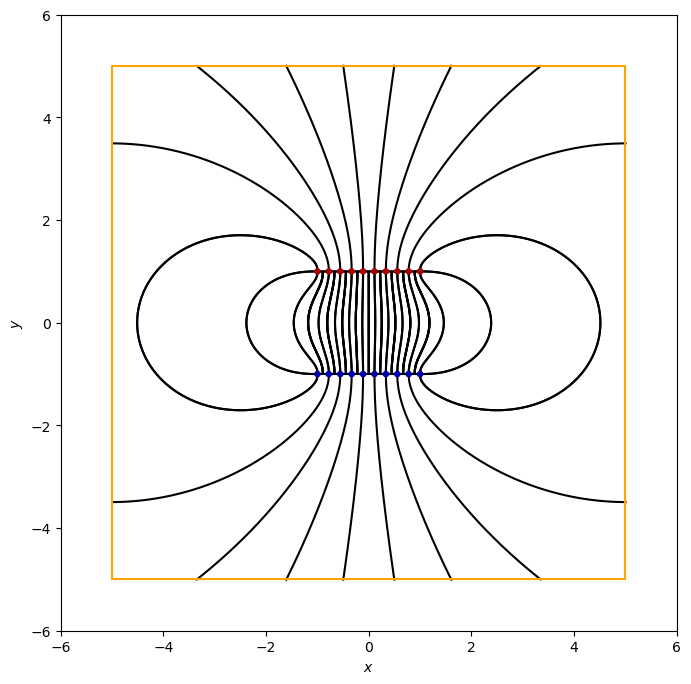

In [ ]:
N, d = 10, 2
draw_streamlines(N, d)

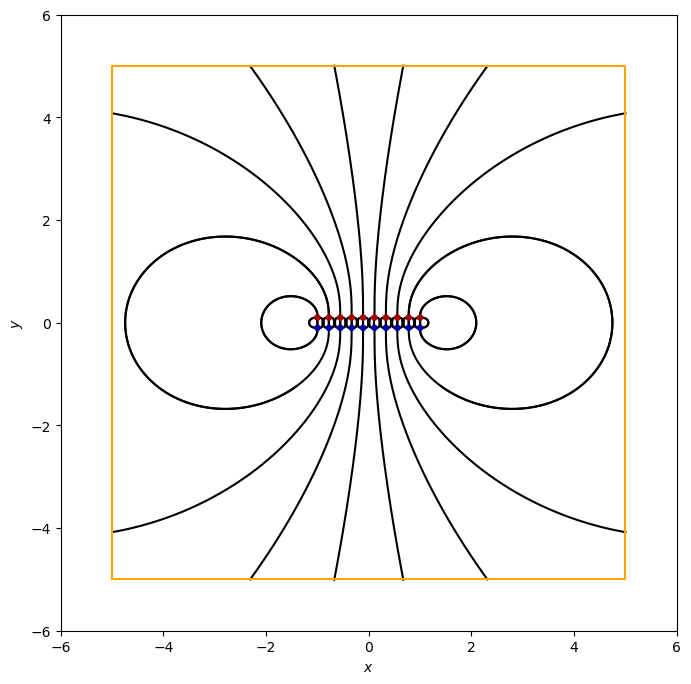

In [ ]:
N, d = 10, 0.2
draw_streamlines(N, d)